## Preparing the environment

In [1]:
import os
import random
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss

from datasets import load_dataset, Dataset
import transformers
from accelerate import Accelerator

from tqdm import tqdm

import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"

data_path = "../data"

In [2]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False

#### Setting constants

In [3]:
context_length = 128

batch_size = 128
num_workers = 8
global_batch_size = 512
accumulation_steps = global_batch_size // batch_size

learning_rate = 3e-4
betas = (0.9, 0.95)
eps = 1e-8
gradient_clipping = 1.0
weight_decay = 0.1

warmup_iters = 256

train_iters = 2048
eval_save_interval = 50
val_iters = 20

model_name = "EleutherAI/pythia-14m"
model_revision = "step0"

dataset_path = "allenai/c4"
dataset_name = "realnewslike"

## Loading dataset

In [4]:
dataset = load_dataset(dataset_path, dataset_name)
dataset = dataset.with_format("torch")

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/76 [00:00<?, ?it/s]

In [5]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, revision=model_revision)

def tokenize(data):
    outputs = tokenizer(
        data["text"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = list()
    # deleting samples shorter than context_length tokens
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
if os.path.exists(os.path.join(data_path, "train_dataset")):
    train_dataset = Dataset.load_from_disk(os.path.join(data_path, "train_dataset"))
else:
    train_dataset = dataset["train"].map(
        tokenize, batched=True, remove_columns=dataset["train"].column_names
    )
    train_dataset.save_to_disk(os.path.join(data_path, "train_dataset"))


if os.path.exists(os.path.join(data_path, "val_dataset")):
    val_dataset = Dataset.load_from_disk(os.path.join(data_path, "val_dataset"))
else:
    val_dataset = dataset["validation"].map(
        tokenize, batched=True, remove_columns=dataset["validation"].column_names
    )
    val_dataset.save_to_disk(os.path.join(data_path, "val_dataset"))

Loading dataset from disk:   0%|          | 0/58 [00:00<?, ?it/s]

In [7]:
val_dataset = val_dataset.select(range(len(val_dataset) // (batch_size * val_iters) * (batch_size * val_iters)))

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Training

### Full-rank Training

In [9]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              worker_init_fn=seed_worker,
                              generator=g)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=num_workers,
                            worker_init_fn=seed_worker,
                            generator=g,
                            drop_last=True)

In [10]:
model = transformers.AutoModelForCausalLM.from_pretrained(model_name,
                                                          revision=model_revision,
                                                          attn_implementation="flash_attention_2").to(device)

You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in GPTNeoXForCausalLM is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in GPTNeoXModel is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=betas, eps=eps, weight_decay=weight_decay)

scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_iters, num_training_steps=train_iters)

loss_fct = CrossEntropyLoss()

In [12]:
accelerator = Accelerator(mixed_precision="fp16")

model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader
)

In [13]:
def evaluate(model, val_dataloader, val_iters):
    model.eval()
    val_losses = list()
    for step, batch in enumerate(val_dataloader):
        with torch.inference_mode():
            outputs = model(batch["input_ids"], labels=batch["input_ids"])
            val_losses.append(outputs.loss.item())
        if step + 1 >= val_iters:
            break
    val_loss = np.mean(val_losses)
    return val_loss
    

In [14]:
model.train()
train_losses = dict()
val_losses = dict()
last_losses = list()
completed_steps = 0

for step, batch in tqdm(
        enumerate(train_dataloader, start=1), total=int(train_iters * accumulation_steps)
    ):
    output = model(batch["input_ids"], labels=batch["input_ids"])
    loss = output.loss / accumulation_steps
    last_losses.append(loss.item())
    accelerator.backward(loss)
    
    if step % accumulation_steps == 0:
        accelerator.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        completed_steps += 1
    
    if step % (eval_save_interval * accumulation_steps) == 0:
        train_losses[completed_steps] = np.mean(last_losses)
        val_losses[completed_steps] = evaluate(model, val_dataloader, val_iters)
        print(
            {
                "steps": completed_steps,
                "loss/train": train_losses[completed_steps],
                "loss/val": val_losses[completed_steps],
            }
        )
        last_losses = list()
        model.train()
        accelerator.wait_for_everyone()
    
    if completed_steps >= train_iters:
        train_losses[completed_steps] = np.mean(last_losses)
        val_losses[completed_steps] = evaluate(model, val_dataloader, val_iters)
        print(
            {
                "steps": completed_steps,
                "loss/train": train_losses[completed_steps],
                "loss/val": val_losses[completed_steps],
            }
        )
        last_losses = list()
        model.train()
        accelerator.wait_for_everyone()
        break

  1%|          | 202/16384 [00:21<1:04:54,  4.15it/s]

{'steps': 50, 'loss/train': 10.780559368133545, 'loss/val': 10.399091005325317}


  2%|▏         | 402/16384 [00:39<52:51,  5.04it/s]  

{'steps': 100, 'loss/train': 10.08839741230011, 'loss/val': 9.763186502456666}


  4%|▎         | 602/16384 [00:57<52:10,  5.04it/s]  

{'steps': 150, 'loss/train': 9.410350723266601, 'loss/val': 9.020652389526367}


  5%|▍         | 802/16384 [01:15<52:41,  4.93it/s]  

{'steps': 200, 'loss/train': 8.62272624015808, 'loss/val': 8.21163387298584}


  6%|▌         | 1002/16384 [01:33<52:14,  4.91it/s]  

{'steps': 250, 'loss/train': 7.847839140892029, 'loss/val': 7.5181759119033815}


  7%|▋         | 1202/16384 [01:51<50:52,  4.97it/s]  

{'steps': 300, 'loss/train': 7.29013379573822, 'loss/val': 7.110232329368591}


  9%|▊         | 1402/16384 [02:09<50:15,  4.97it/s]  

{'steps': 350, 'loss/train': 6.978482043743133, 'loss/val': 6.851217484474182}


 10%|▉         | 1602/16384 [02:28<50:02,  4.92it/s]  

{'steps': 400, 'loss/train': 6.748984401226044, 'loss/val': 6.644704794883728}


 11%|█         | 1802/16384 [02:46<49:10,  4.94it/s]  

{'steps': 450, 'loss/train': 6.587783052921295, 'loss/val': 6.527017712593079}


 12%|█▏        | 2002/16384 [03:04<47:51,  5.01it/s]  

{'steps': 500, 'loss/train': 6.452655203342438, 'loss/val': 6.430298709869385}


 13%|█▎        | 2202/16384 [03:22<47:46,  4.95it/s]  

{'steps': 550, 'loss/train': 6.353975298404694, 'loss/val': 6.302053332328796}


 15%|█▍        | 2402/16384 [03:39<46:34,  5.00it/s]  

{'steps': 600, 'loss/train': 6.270507206916809, 'loss/val': 6.228275728225708}


 16%|█▌        | 2602/16384 [03:57<45:32,  5.04it/s]

{'steps': 650, 'loss/train': 6.196363475322723, 'loss/val': 6.192988395690918}


 17%|█▋        | 2802/16384 [04:15<45:10,  5.01it/s]

{'steps': 700, 'loss/train': 6.143109438419342, 'loss/val': 6.117082047462463}


 18%|█▊        | 3002/16384 [04:33<45:16,  4.93it/s]

{'steps': 750, 'loss/train': 6.088233499526978, 'loss/val': 6.076258683204651}


 20%|█▉        | 3202/16384 [04:51<44:21,  4.95it/s]

{'steps': 800, 'loss/train': 6.049668819904327, 'loss/val': 6.020809006690979}


 21%|██        | 3402/16384 [05:09<44:13,  4.89it/s]

{'steps': 850, 'loss/train': 6.000684537887573, 'loss/val': 5.993635177612305}


 22%|██▏       | 3602/16384 [05:27<43:03,  4.95it/s]

{'steps': 900, 'loss/train': 5.9590891027450565, 'loss/val': 5.961964559555054}


 23%|██▎       | 3802/16384 [05:46<42:55,  4.89it/s]

{'steps': 950, 'loss/train': 5.928410611152649, 'loss/val': 5.926446843147278}


 24%|██▍       | 4002/16384 [06:04<41:13,  5.00it/s]

{'steps': 1000, 'loss/train': 5.894034323692321, 'loss/val': 5.887158751487732}


 26%|██▌       | 4202/16384 [06:22<41:04,  4.94it/s]

{'steps': 1050, 'loss/train': 5.866704695224762, 'loss/val': 5.875916647911072}


 27%|██▋       | 4402/16384 [06:40<39:49,  5.01it/s]

{'steps': 1100, 'loss/train': 5.835069890022278, 'loss/val': 5.848302984237671}


 28%|██▊       | 4602/16384 [06:58<39:36,  4.96it/s]

{'steps': 1150, 'loss/train': 5.80264044046402, 'loss/val': 5.8008613109588625}


 29%|██▉       | 4802/16384 [07:16<38:26,  5.02it/s]

{'steps': 1200, 'loss/train': 5.785845930576325, 'loss/val': 5.804502415657043}


 31%|███       | 5002/16384 [07:34<38:04,  4.98it/s]

{'steps': 1250, 'loss/train': 5.758355851173401, 'loss/val': 5.770703458786011}


 32%|███▏      | 5202/16384 [07:52<37:46,  4.93it/s]

{'steps': 1300, 'loss/train': 5.73995845079422, 'loss/val': 5.715322780609131}


 33%|███▎      | 5402/16384 [08:10<36:56,  4.96it/s]

{'steps': 1350, 'loss/train': 5.709344205856323, 'loss/val': 5.694619584083557}


 34%|███▍      | 5602/16384 [08:28<35:50,  5.01it/s]

{'steps': 1400, 'loss/train': 5.692578740119934, 'loss/val': 5.70425181388855}


 35%|███▌      | 5802/16384 [08:46<35:20,  4.99it/s]

{'steps': 1450, 'loss/train': 5.681561603546142, 'loss/val': 5.69058518409729}


 37%|███▋      | 6002/16384 [09:04<34:22,  5.03it/s]

{'steps': 1500, 'loss/train': 5.655179395675659, 'loss/val': 5.670115399360657}


 38%|███▊      | 6202/16384 [09:22<34:05,  4.98it/s]

{'steps': 1550, 'loss/train': 5.641716434955597, 'loss/val': 5.637247800827026}


 39%|███▉      | 6402/16384 [09:40<33:13,  5.01it/s]

{'steps': 1600, 'loss/train': 5.622077674865722, 'loss/val': 5.618436670303344}


 40%|████      | 6602/16384 [09:58<32:39,  4.99it/s]

{'steps': 1650, 'loss/train': 5.605897150039673, 'loss/val': 5.617273902893066}


 42%|████▏     | 6802/16384 [10:16<32:01,  4.99it/s]

{'steps': 1700, 'loss/train': 5.593979847431183, 'loss/val': 5.593816518783569}


 43%|████▎     | 7002/16384 [10:34<31:20,  4.99it/s]

{'steps': 1750, 'loss/train': 5.573850901126861, 'loss/val': 5.563529062271118}


 44%|████▍     | 7202/16384 [10:51<30:43,  4.98it/s]

{'steps': 1800, 'loss/train': 5.56626800775528, 'loss/val': 5.5626074314117435}


 45%|████▌     | 7402/16384 [11:09<30:28,  4.91it/s]

{'steps': 1850, 'loss/train': 5.540985126495361, 'loss/val': 5.545014238357544}


 46%|████▋     | 7602/16384 [11:27<29:31,  4.96it/s]

{'steps': 1900, 'loss/train': 5.538509361743927, 'loss/val': 5.531918168067932}


 48%|████▊     | 7802/16384 [11:45<28:29,  5.02it/s]

{'steps': 1950, 'loss/train': 5.528109931945801, 'loss/val': 5.535897135734558}


 49%|████▉     | 8002/16384 [12:04<27:57,  5.00it/s]

{'steps': 2000, 'loss/train': 5.509976484775543, 'loss/val': 5.5149661779403685}


 50%|█████     | 8202/16384 [12:22<27:22,  4.98it/s]

{'steps': 2050, 'loss/train': 5.499758024215698, 'loss/val': 5.51806914806366}


 51%|█████▏    | 8402/16384 [12:40<26:49,  4.96it/s]

{'steps': 2100, 'loss/train': 5.494748044013977, 'loss/val': 5.492941427230835}


 53%|█████▎    | 8602/16384 [12:58<26:12,  4.95it/s]

{'steps': 2150, 'loss/train': 5.481639487743378, 'loss/val': 5.463298416137695}


 54%|█████▎    | 8802/16384 [13:16<25:30,  4.95it/s]

{'steps': 2200, 'loss/train': 5.471640870571137, 'loss/val': 5.484452629089356}


 55%|█████▍    | 9002/16384 [13:34<24:33,  5.01it/s]

{'steps': 2250, 'loss/train': 5.463740742206573, 'loss/val': 5.464700508117676}


 56%|█████▌    | 9202/16384 [13:52<23:55,  5.00it/s]

{'steps': 2300, 'loss/train': 5.455627584457398, 'loss/val': 5.475521206855774}


 57%|█████▋    | 9402/16384 [14:10<23:16,  5.00it/s]

{'steps': 2350, 'loss/train': 5.444607212543487, 'loss/val': 5.447438502311707}


 59%|█████▊    | 9602/16384 [14:28<23:02,  4.91it/s]

{'steps': 2400, 'loss/train': 5.439765717983246, 'loss/val': 5.4389677286148075}


 60%|█████▉    | 9802/16384 [14:46<22:13,  4.93it/s]

{'steps': 2450, 'loss/train': 5.436007788181305, 'loss/val': 5.445888638496399}


 61%|██████    | 10002/16384 [15:04<21:39,  4.91it/s]

{'steps': 2500, 'loss/train': 5.425034625530243, 'loss/val': 5.425344061851502}


 62%|██████▏   | 10202/16384 [15:22<20:51,  4.94it/s]

{'steps': 2550, 'loss/train': 5.416674597263336, 'loss/val': 5.421005415916443}


 63%|██████▎   | 10402/16384 [15:40<19:54,  5.01it/s]

{'steps': 2600, 'loss/train': 5.415861113071442, 'loss/val': 5.428444337844849}


 65%|██████▍   | 10602/16384 [15:57<18:24,  5.23it/s]

{'steps': 2650, 'loss/train': 5.403671793937683, 'loss/val': 5.4129891872406}


 66%|██████▌   | 10802/16384 [16:14<17:38,  5.28it/s]

{'steps': 2700, 'loss/train': 5.4003248572349545, 'loss/val': 5.386792373657227}


 67%|██████▋   | 11002/16384 [16:30<17:12,  5.21it/s]

{'steps': 2750, 'loss/train': 5.394875018596649, 'loss/val': 5.407212495803833}


 68%|██████▊   | 11202/16384 [16:47<16:24,  5.26it/s]

{'steps': 2800, 'loss/train': 5.3983076024055485, 'loss/val': 5.411019635200501}


 70%|██████▉   | 11402/16384 [17:04<15:40,  5.30it/s]

{'steps': 2850, 'loss/train': 5.395638496875763, 'loss/val': 5.379046964645386}


 71%|███████   | 11602/16384 [17:20<14:59,  5.32it/s]

{'steps': 2900, 'loss/train': 5.38472259759903, 'loss/val': 5.390744233131409}


 72%|███████▏  | 11802/16384 [17:37<14:25,  5.29it/s]

{'steps': 2950, 'loss/train': 5.377432005405426, 'loss/val': 5.375630617141724}


 73%|███████▎  | 12002/16384 [17:54<13:46,  5.30it/s]

{'steps': 3000, 'loss/train': 5.374110357761383, 'loss/val': 5.375258541107177}


 74%|███████▍  | 12202/16384 [18:10<13:16,  5.25it/s]

{'steps': 3050, 'loss/train': 5.3730171465873715, 'loss/val': 5.373067474365234}


 76%|███████▌  | 12402/16384 [18:27<12:29,  5.31it/s]

{'steps': 3100, 'loss/train': 5.361218254566193, 'loss/val': 5.371809768676758}


 77%|███████▋  | 12602/16384 [18:44<12:01,  5.24it/s]

{'steps': 3150, 'loss/train': 5.368299782276154, 'loss/val': 5.372132635116577}


 78%|███████▊  | 12802/16384 [19:01<11:28,  5.20it/s]

{'steps': 3200, 'loss/train': 5.364755308628082, 'loss/val': 5.375857949256897}


 79%|███████▉  | 13002/16384 [19:17<10:46,  5.23it/s]

{'steps': 3250, 'loss/train': 5.363671824932099, 'loss/val': 5.368483519554138}


 81%|████████  | 13202/16384 [19:34<10:08,  5.23it/s]

{'steps': 3300, 'loss/train': 5.355541024208069, 'loss/val': 5.371026253700256}


 82%|████████▏ | 13402/16384 [19:51<09:32,  5.21it/s]

{'steps': 3350, 'loss/train': 5.359645826816559, 'loss/val': 5.37272047996521}


 83%|████████▎ | 13602/16384 [20:08<08:55,  5.19it/s]

{'steps': 3400, 'loss/train': 5.36193331003189, 'loss/val': 5.348284268379212}


 84%|████████▍ | 13802/16384 [20:24<08:09,  5.27it/s]

{'steps': 3450, 'loss/train': 5.35095342874527, 'loss/val': 5.357110977172852}


 85%|████████▌ | 14002/16384 [20:41<07:34,  5.24it/s]

{'steps': 3500, 'loss/train': 5.34943160533905, 'loss/val': 5.35803337097168}


 87%|████████▋ | 14202/16384 [20:58<06:57,  5.23it/s]

{'steps': 3550, 'loss/train': 5.350969851016998, 'loss/val': 5.361786651611328}


 88%|████████▊ | 14402/16384 [21:14<06:14,  5.29it/s]

{'steps': 3600, 'loss/train': 5.350582792758941, 'loss/val': 5.359561038017273}


 89%|████████▉ | 14602/16384 [21:31<05:38,  5.26it/s]

{'steps': 3650, 'loss/train': 5.344777638912201, 'loss/val': 5.379327774047852}


 90%|█████████ | 14802/16384 [21:48<04:58,  5.31it/s]

{'steps': 3700, 'loss/train': 5.346993839740753, 'loss/val': 5.366307306289673}


 92%|█████████▏| 15002/16384 [22:04<04:22,  5.26it/s]

{'steps': 3750, 'loss/train': 5.346523756980896, 'loss/val': 5.365579962730408}


 93%|█████████▎| 15202/16384 [22:21<03:43,  5.29it/s]

{'steps': 3800, 'loss/train': 5.344150793552399, 'loss/val': 5.349811792373657}


 94%|█████████▍| 15402/16384 [22:38<03:05,  5.29it/s]

{'steps': 3850, 'loss/train': 5.347802324295044, 'loss/val': 5.359348797798157}


 95%|█████████▌| 15602/16384 [22:54<02:28,  5.27it/s]

{'steps': 3900, 'loss/train': 5.34691143989563, 'loss/val': 5.344469165802002}


 96%|█████████▋| 15802/16384 [23:11<01:50,  5.28it/s]

{'steps': 3950, 'loss/train': 5.341915590763092, 'loss/val': 5.327129316329956}


 98%|█████████▊| 16002/16384 [23:28<01:11,  5.31it/s]

{'steps': 4000, 'loss/train': 5.347916305065155, 'loss/val': 5.350028491020202}


 99%|█████████▉| 16202/16384 [23:44<00:34,  5.30it/s]

{'steps': 4050, 'loss/train': 5.345053737163544, 'loss/val': 5.362320756912231}


100%|█████████▉| 16383/16384 [23:59<00:00, 11.38it/s]

{'steps': 4096, 'loss/train': 5.347538538601087, 'loss/val': 5.374599456787109}


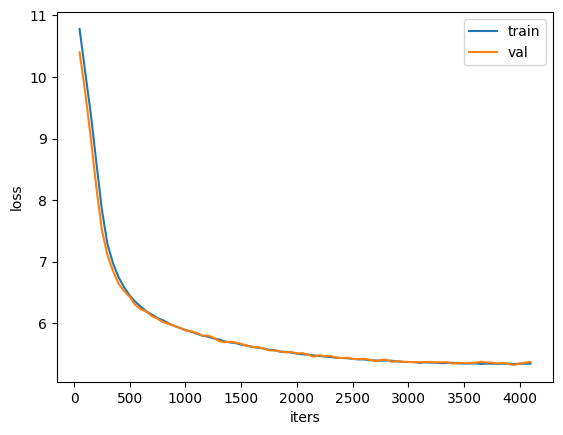

In [15]:
plt.plot(*zip(*train_losses.items()))
plt.plot(*zip(*val_losses.items()))
plt.legend(['train', 'val'], loc='upper right')
plt.ylabel('loss')
plt.xlabel('iters')
plt.show()